In [13]:
# This notebook shows an example of how to decode the data in the EvAAL API format to pandas DataFrame.
# Please note that the format of the txt file in ../trials/ is what returned through EvAAL API in the competition.
# In the real competition in September, you need to get data throught EvAAL API.

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation as R
from PIL import Image


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [14]:


LOG_FILE_PATH = "../trials/4_1_51.txt"
GT_CSV_PATH = "../gt/2_3_gt.csv"

GIS_BASE_PATH = "../gis/"
BEACON_LIST_PATH = GIS_BASE_PATH + "beacon_list.csv"
FLOOR_NAMES = ["FLU01", "FLU02", "FLD01"]

In [15]:
def match_data(angle_df: pd.DataFrame, peek_t: pd.Series):
    matched_df = pd.DataFrame()
    for t in peek_t:
        matched_row = angle_df[np.isclose(
            angle_df['ts'], t, atol=0.005)]
        matched_df = pd.concat([matched_df, matched_row])
    return matched_df


def calculate_cumulative_displacement(ts: pd.Series, angle_data: pd.Series, step_length: float,initial_point:dict[str,float],initial_timestamp:float=0.0):
    x_displacement = step_length * np.cos(angle_data)
    y_displacement = step_length * np.sin(angle_data)

    init_data_frame = pd.DataFrame(
        {
            "ts": [initial_timestamp],
            "x_displacement": initial_point["x"],
            "y_displacement": initial_point["y"]
        }
    )

    return pd.concat([init_data_frame, pd.DataFrame(
        {
            "ts": ts,
            "x_displacement": x_displacement.cumsum()+initial_point["x"],
            "y_displacement": y_displacement.cumsum()+initial_point["y"]
        }
    )])


def rotate_cumulative_displacement(df, angle,initial_point:dict[str,float]):
    # dfをコピー
    df = df.copy()
    # 原点に平行移動
    df.x_displacement = df.x_displacement - initial_point["x"]
    df.y_displacement = df.y_displacement - initial_point["y"]

    # rotate displacement
    new_df = pd.DataFrame()
    new_df['ts'] = df.ts
    new_df['x_displacement'] = df.x_displacement * np.cos(angle) - \
        df.y_displacement * np.sin(angle)
    new_df['y_displacement'] = df.x_displacement * np.sin(angle) + \
        df.y_displacement * np.cos(angle)
    
    # 元の位置に戻す
    new_df.x_displacement = new_df.x_displacement + initial_point["x"]
    new_df.y_displacement = new_df.y_displacement + initial_point["y"]

    return new_df

def filter_strong_blescans(blescans:pd.DataFrame,ts:np.float32,rssi:np.float32):
    """
    Filter out blescans that have rssi value greater than -76 and ts value less than 30.
    """
    strong_blescans = blescans[(blescans['rssi'] > rssi)
                               & (blescans['ts'] < ts)]
    strong_blescans.reset_index(inplace=True)
    return strong_blescans



def load_beacons_and_merge(BEACON_LIST_PATH, strong_blescans):
    df_beacons = pd.read_csv(BEACON_LIST_PATH)
    strong_blescans = pd.merge(
        strong_blescans, df_beacons, on='bdaddress', how='left')
    return strong_blescans

def compute_vector(point1:dict[str,np.float64], point2:dict[str,np.float64]):
    vector = {
        'x': point2['x'] - point1['x'],
        'y': point2['y'] - point1['y']
    }
    return vector

def compute_angle_and_scale(vector1, vector2):
    dot = vector1['x'] * vector2['x'] + vector1['y'] * vector2['y']
    norm_vector1 = np.sqrt(vector1['x']**2 + vector1['y']**2)
    norm_vector2 = np.sqrt(vector2['x']**2 + vector2['y']**2)
    scale = norm_vector2 / norm_vector1
    cos = dot / (norm_vector1 * norm_vector2)
    angle = np.arccos(cos)
    cross = vector1['x'] * vector2['y'] - vector1['y'] * vector2['x']
    
    if cross < 0:
        angle = 2 * np.pi - angle
    
    return scale, angle

def affine_transform(displacement_df, center_point:dict[str,np.float64], scale, angle):
    displacement_df = displacement_df.copy()

    # 原点に平行移動
    displacement_df['x_displacement'] -= center_point['x']
    displacement_df['y_displacement'] -= center_point['y']

    # アフィン変換（拡大）
    displacement_df['x_displacement'] *= scale
    displacement_df['y_displacement'] *= scale

    # アフィン変換（半時計回転）
    new_x_displacement = displacement_df['x_displacement'] * \
        np.cos(angle) - \
        displacement_df['y_displacement'] * np.sin(angle)
    new_y_displacement = displacement_df['x_displacement'] * \
        np.sin(angle) + \
        displacement_df['y_displacement'] * np.cos(angle)

    displacement_df['x_displacement'] = new_x_displacement
    displacement_df['y_displacement'] = new_y_displacement

    #  平行移動（原点に移動させた分元に戻す）
    displacement_df['x_displacement'] += center_point['x']
    displacement_df['y_displacement'] += center_point['y']
    
    return displacement_df


def compute_affine_transformation(center_of_rotation_point:dict[str,np.float64] ,befor_of_correction_point:dict[str,np.float64] ,after_of_correction_point:dict[str,np.float64] , cumulative_displacement_df:pd.DataFrame): 
    cumulative_displacement_df = cumulative_displacement_df.copy()

    # centerからbeforeまでのベクトル
    vector_center_to_before = compute_vector(
        center_of_rotation_point, befor_of_correction_point)

    # centerからafterまでのベクトル
    vector_center_to_after = compute_vector(
        center_of_rotation_point, after_of_correction_point)

    scale, angle = compute_angle_and_scale(
        vector_center_to_before, vector_center_to_after)
    
    cumulative_displacement_df = affine_transform(
        cumulative_displacement_df, center_of_rotation_point, scale, angle)

    return cumulative_displacement_df

def unique_blescans_fn(strong_blescans):
    prev_item_control_number = strong_blescans['control_number'].values[0]
    unique_blescans = strong_blescans.iloc[[0]]
    # strong_blescansをfor文で回す
    for index, item in strong_blescans.iterrows():
        if item['control_number'] != prev_item_control_number :
            unique_blescans = pd.concat(
                [unique_blescans, strong_blescans.iloc[[index]]])
            prev_item_control_number = item['control_number']
    # unique_blescansの1行目を削除する
    unique_blescans = unique_blescans.iloc[1:]

    # control_numberが一意のものを抽出
    unique_blescans = unique_blescans[unique_blescans['bdaddress'].duplicated(
        keep=False) == False]

    return unique_blescans

def filter_strongest_beacon_per_interval(df:pd.DataFrame, interval_seconds=10):
    """
    Filter beacon data by selecting the strongest signal in each interval.

    Args:
    df (pandas.DataFrame): DataFrame containing the beacon data.
    interval_seconds (int): Interval in seconds to group the data and select the strongest signal.

    Returns:
    filtered_df (pandas.DataFrame): DataFrame with filtered data.
    """
    # Create a new column for the interval index
    df['interval_index'] = (df['ts'] // interval_seconds).astype(int)

    # Group by the interval index and select the row with the maximum RSSI value in each group
    idx:pd.Series = df.groupby(['interval_index'])['rssi'].transform(max) == df['rssi']
    filtered_df = df[idx]

    filtered_df = filtered_df.drop_duplicates(subset=['interval_index'])

    # Drop the interval index column
    filtered_df = filtered_df.drop(columns=['interval_index'])



    return filtered_df



def search_optimal_angle(displacement_df:pd.DataFrame,gt_ref:pd.DataFrame,strong_blescans:pd.DataFrame):
    displacement_df_copy = displacement_df.copy()
    # 探索する角度の範囲
    angle_range = np.arange(0, 2*np.pi, 0.01)
    angle_and_euclidean_list:list[dict[str,float]] = []

    for angle in angle_range:
        new_df = rotate_cumulative_displacement(displacement_df_copy, angle,{'x':gt_ref.x[0],'y':gt_ref.y[0]})
        total_euclidean_distance = 0
        for _, row in strong_blescans.iterrows():
            # のtsとstrong_blescansのtsが一番近い行を取得
            nearest_row = new_df.iloc[(
                new_df['ts'] - row['ts']).abs().argsort()[:1]]
            # ユークリッド距離を計算
            euclidean_distance = np.sqrt(
                (nearest_row['x_displacement'].values[0]-row['x'])**2 + (nearest_row['y_displacement'].values[0]-row['y'])**2)
            total_euclidean_distance += euclidean_distance
            
        angle_and_euclidean_list.append({"angle":angle,"total_euclidean_distance":total_euclidean_distance})

    # 一番ユークリッド距離が小さいangleとeuclidean_distanceを取得
    angle_and_euclidean = min(angle_and_euclidean_list, key=lambda x: x['total_euclidean_distance'])

    return angle_and_euclidean['angle']

def search_optimal_drift_and_step_length(gyro: pd.DataFrame,acc: pd.DataFrame,gt_ref:pd.DataFrame,peaks:np.ndarray):
    gyro_copy = gyro.copy()

    # 探索するドリフトの範囲
    drift_range = np.arange(0, 0.3, 0.001)
    # 探索するステップ長の範囲
    step_length_range = np.arange(0.3, 0.6, 0.1)

    drift_and_euclidean_list:list[dict[str,float]] = []

    for step_length in step_length_range:

        # ドリフトを加えた角速度を計算
        for drift in drift_range:
            gyro_copy['new_x'] = gyro_copy['x'] - drift
            angle_copy = pd.DataFrame()
            # 角速度から角度に変換
            angle_copy['ts'] = gyro_copy['ts']
            angle_copy['x'] = gyro_copy['new_x'].cumsum() * 0.01

            peek_angle_ = match_data(angle_copy, acc.ts[peaks])

            cumulative_displacement_df_copy = calculate_cumulative_displacement(
                peek_angle_.ts, peek_angle_['x'], step_length, {"x": gt_ref.x[0], "y": gt_ref.y[0]})
            cumulative_displacement_df_copy.reset_index(inplace=True, drop=True)
            # cumulative_displacement_df_copyの最後の行の値を取得
            last_row = cumulative_displacement_df_copy.tail(1)
            # ユークリッド距離を計算
            euclidean_distance = np.sqrt(
                (last_row['x_displacement'].values[0]-43)**2 + (last_row['y_displacement'].values[0]-12)**2)
            
            drift_and_euclidean_list.append({"drift":drift,"step_length":step_length,"euclidean_distance":euclidean_distance})
 
    # 一番ユークリッド距離が小さいドリフトを取得
    optimal_drift_and_euclidean = min(drift_and_euclidean_list, key=lambda x: x['euclidean_distance'])

    return optimal_drift_and_euclidean


def search_optimal_drift_from_gyro(gyro: pd.DataFrame,acc: pd.DataFrame,gt_ref,peaks:np.ndarray):
    gyro_copy = gyro.copy()

    # 探索するドリフトの範囲
    drift_range = np.arange(0, 0.3, 0.001)

    drift_and_euclidean_list:list[dict[str,float]] = []

    # ドリフトを加えた角速度を計算
    for drift in drift_range:
        gyro_copy['new_x'] = gyro_copy['x'] - drift
        angle_copy = pd.DataFrame()
        # 角速度から角度に変換
        angle_copy['ts'] = gyro_copy['ts']
        angle_copy['x'] = gyro_copy['new_x'].cumsum() * 0.01

        peek_angle = match_data(angle_copy, acc.ts[peaks])

        cumulative_displacement_df_copy = calculate_cumulative_displacement(
            peek_angle.ts, peek_angle['x'],0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]})
        cumulative_displacement_df_copy.reset_index(inplace=True, drop=True)
        # cumulative_displacement_df_copyの最後の行の値を取得
        last_row = cumulative_displacement_df_copy.tail(1)
        # ユークリッド距離を計算
        euclidean_distance = np.sqrt(
            (last_row['x_displacement'].values[0]-gt_ref.x[1])**2 + (last_row['y_displacement'].values[0]-gt_ref.y[1])**2)
        
        drift_and_euclidean_list.append({"drift":drift,"euclidean_distance":euclidean_distance})

    
    # 一番ユークリッド距離が小さいドリフトを取得
    optimal_drift_and_euclidean = min(drift_and_euclidean_list, key=lambda x: x['euclidean_distance'])

    return optimal_drift_and_euclidean



def convert_to_peek_angle(gyro: pd.DataFrame, acc: pd.DataFrame, peaks: np.ndarray):
    gyro_copy = gyro.copy()
    angle_copy = pd.DataFrame()
    # 角速度から角度に変換
    angle_copy['ts'] = gyro_copy['ts']
    angle_copy['x'] = gyro_copy['x'].cumsum() * 0.01
    peek_angle = match_data(angle_copy, acc.ts[peaks])

    return peek_angle



def convert_to_angle_from_cumulative_displacement(cumulative_displacement_df: pd.DataFrame):
    #コピーの作成
    cumulative_displacement_df_copy = cumulative_displacement_df.copy()

    # x方向とy方向の変位（累積変位の差分）を計算
    delta_x = cumulative_displacement_df_copy['x_displacement'].diff()
    delta_y = cumulative_displacement_df_copy['y_displacement'].diff()

    # 各ステップ間の相対角度を計算
    relative_angle = np.arctan2(delta_y, delta_x)

    # 1行目を削除
    relative_angle = relative_angle.drop(relative_angle.index[0])

    return pd.DataFrame(
        {
            "ts": cumulative_displacement_df_copy["ts"].iloc[1:],  # We drop the first timestamp due to diff
            "x": relative_angle
        }
    )
           


def convert_to_gyro(df: pd.DataFrame, sampling_frequency: float):
    # Calculate angle from displacement data
    angle_data = np.arctan2(df["y_displacement"], df["x_displacement"])
    # Calculate the difference between adjacent angle data
    angle_diff = np.diff(angle_data)

    # Convert the difference in angle to angular velocity
    gyro_data = angle_diff / sampling_frequency

    return pd.DataFrame(
        {
            "ts": df["ts"].iloc[1:],  # We drop the first timestamp due to diff
            "x": gyro_data
        }
    )

def remove_drift_and_convert_to_angle(gyro: pd.DataFrame, acc: pd.DataFrame, drift: float, peaks: np.ndarray):
    gyro_copy = gyro.copy()
    # ドリフトが一定と仮定して除去
    gyro_copy['x'] = gyro_copy['x'] - drift
    angle_copy = pd.DataFrame()
    # 角速度から角度に変換
    angle_copy['ts'] = gyro_copy['ts']
    angle_copy['x'] = gyro_copy['x'].cumsum() * 0.01
    peek_angle = match_data(angle_copy, acc.ts[peaks])

    return peek_angle

In [16]:

from collections import defaultdict

# Prepare containers for the data
data = defaultdict(list)

with open(LOG_FILE_PATH) as f:
    for line in f:
        line_contents = line.rstrip('\n').split(';')
        DATA_TYPE = line_contents[0]

        if DATA_TYPE == 'BLUE':
            data['BLUE'].append({
                'ts': float(line_contents[1]),
                'bdaddress': line_contents[2],
                'rssi': int(line_contents[4])
            })

        elif DATA_TYPE in ['ACCE', 'GYRO', 'MAGN']:
            record = {
                'ts': float(line_contents[1]),
                'accuracy': int(line_contents[6]),
                'x': float(line_contents[3]),
                'y': float(line_contents[4]),
                'z': float(line_contents[5])
            }
            data[DATA_TYPE].append(record)
        
        elif DATA_TYPE == 'POS3':
            data['POS3'].append({
                '%time': float(line_contents[1]),
                'x': float(line_contents[3]),
                'y': float(line_contents[4]),
                'z': float(line_contents[5]),
                'q0': float(line_contents[6]),
                'q1': float(line_contents[7]),
                'q2': float(line_contents[8]),
                'q3': float(line_contents[9]),
                'floor': line_contents[10]
            })

# Convert lists of dictionaries to dataframes
blescans = pd.DataFrame(data['BLUE'])
acc = pd.DataFrame(data['ACCE'])
gyro = pd.DataFrame(data['GYRO'])
mgf = pd.DataFrame(data['MAGN'])
gt_ref = pd.DataFrame(data['POS3'])

print(gt_ref)


acc.reset_index(inplace=True, drop=True)
gyro.reset_index(inplace=True, drop=True)
mgf.reset_index(inplace=True, drop=True)
gt_ref.reset_index(inplace=True, drop=True)



        %time          x          y         z        q0        q1        q2  \
0    0.004059  43.079905  12.163538  1.320953  0.194603  0.288317  0.324667   
1  181.660239  43.137792  12.098551  1.259271 -0.076098  0.191282  0.674619   

         q3  floor  
0  0.879542  FLU01  
1  0.708879  FLU01  


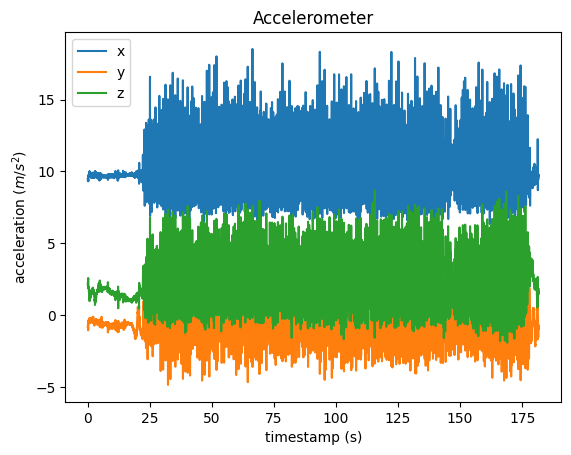

In [17]:

plt.plot(acc.ts, acc[["x", "y", "z"]], label=["x", "y", "z"])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer")
plt.legend()
plt.show()


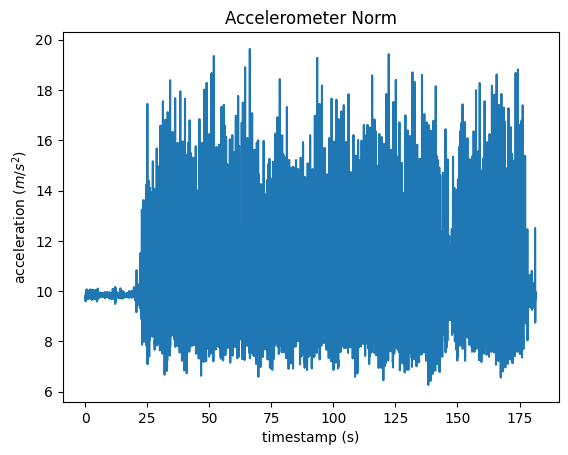

In [18]:

acc['norm'] = np.sqrt(acc['x']**2+acc['y']**2+acc['z']**2)
acc.reset_index()

plt.plot(acc.ts, acc['norm'])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

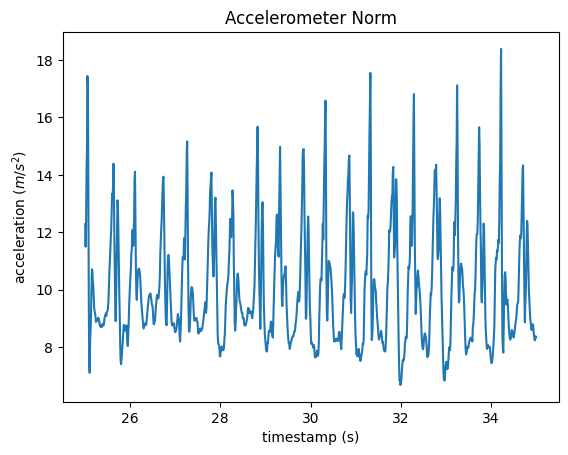

In [19]:

acc['norm'] = np.sqrt(acc['x']**2+acc['y']**2+acc['z']**2)

# 時間が25秒以上50秒未満のデータを抽出
time_filter_acc = acc[(acc.ts >= 25) & (acc.ts < 35)]
time_filter_acc.reset_index(inplace=True, drop=True)

plt.plot(time_filter_acc.ts, time_filter_acc['norm'])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

/var/folders/9p/p2bfdpzj5v5fs4xvn07kwlww0000gn/T/ipykernel_74545/170683450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filter_acc.loc[:, 'rolling_norm'] = time_filter_acc['norm'].rolling(


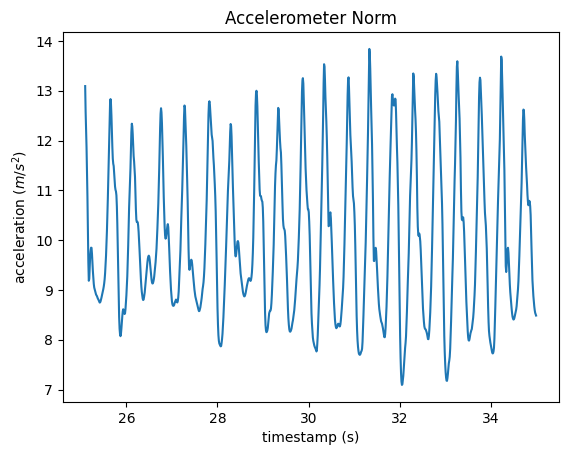

In [20]:

# 移動平均フィルターをかける
time_filter_acc.loc[:, 'rolling_norm'] = time_filter_acc['norm'].rolling(
    10).mean()

plt.plot(time_filter_acc.ts, time_filter_acc['rolling_norm'])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

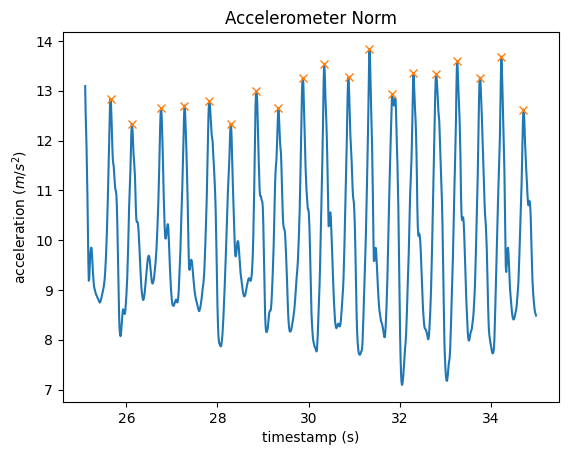

In [21]:
# ピーク検出
from scipy.signal import find_peaks

peaks, _ = find_peaks(time_filter_acc['rolling_norm'], height=12, distance=10)
plt.plot(time_filter_acc.ts, time_filter_acc['rolling_norm'])
plt.plot(time_filter_acc.ts[peaks],
         time_filter_acc['rolling_norm'][peaks], "x")
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()


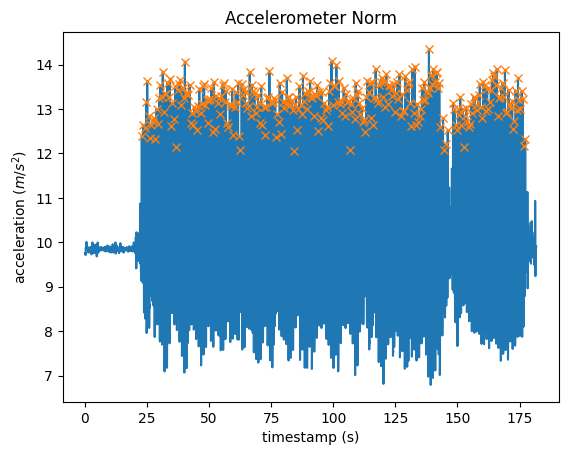

In [22]:

acc['rolling_norm'] = acc['norm'].rolling(10).mean()

peaks, _ = find_peaks(acc['rolling_norm'], height=12, distance=10)
plt.plot(acc.ts, acc['rolling_norm'])
plt.plot(acc.ts[peaks], acc['rolling_norm'][peaks], "x")
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()



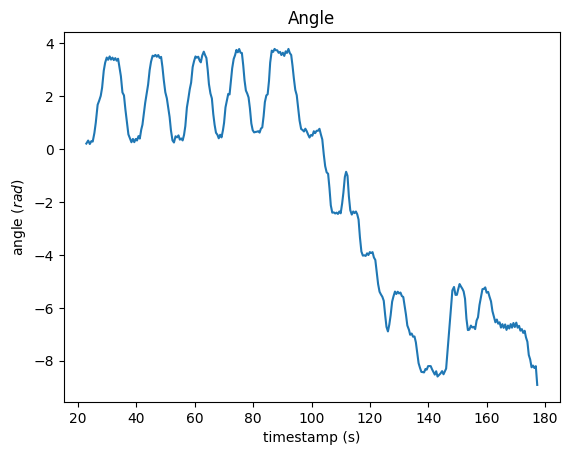

In [23]:


gyro_in_step_timing = pd.DataFrame()
gyro_in_step_timing = match_data(gyro, acc.ts[peaks])

# csvファイルに保存
gyro_in_step_timing.to_csv('./output/gyro_in_step_timing.csv', index=False,columns=['ts','x'])

# ジャイロを積分して角度に変換
angle_in_step_timing = pd.DataFrame()
angle_in_step_timing= convert_to_peek_angle(gyro, acc, peaks)
#csvファイルに保存
angle_in_step_timing.to_csv('./output/angle_in_step_timing.csv', index=False,columns=['ts','x'])

plt.plot(angle_in_step_timing.ts, angle_in_step_timing['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()


angle_in_step_timing = convert_to_peek_angle(gyro, acc, peaks)






In [24]:
def load_bitmap(filename):
    image = Image.open(filename)
    array = np.array(image, dtype=bool)
    return array

# plot map
def plot_map(map_dict,floor_name,dx,dy):
    plt.figure(figsize=[10, 10])
    plt.axis("equal")

    # plot map
    xmax = map_dict[floor_name].shape[0] * dx  # length of map along x axis
    ymax = map_dict[floor_name].shape[1] * dy  # length of map along y axis

    plt.xlim(0, xmax)
    plt.ylim(0, ymax)
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.title(floor_name)
    plt.imshow(np.rot90(map_dict[floor_name]),
            extent=[0, xmax, 0, ymax], cmap="binary", alpha=0.5)
# 1 pixel of bmp represents 0.01 m
dx = 0.01
dy = 0.01

# read bitmap image of the floor movable areas
map_dict = {}
for floor_name in FLOOR_NAMES:
    map_dict[floor_name] = load_bitmap(
        GIS_BASE_PATH + floor_name + "_0.01_0.01.bmp")
df_gt = pd.read_csv(GT_CSV_PATH)
print(df_gt.floor.mode()[0])
floor_name = df_gt.floor.mode()[0]  # get the floor name in the ground truth

plot_map(map_dict,floor_name, dx, dy)


peek_angle = convert_to_peek_angle(gyro,acc,peaks)
cumulative_displacement_df = calculate_cumulative_displacement(peek_angle.ts, peek_angle['x'], 0.5, {"x":gt_ref.x[0],"y":gt_ref.y[0]},gt_ref['%time'][0])

#csvファイルに保存
cumulative_displacement_df.to_csv('./output/cumulative_displacement_df.csv', index=False,columns=['ts','x_displacement','y_displacement'])

plt.colorbar(
    plt.scatter(cumulative_displacement_df.x_displacement, cumulative_displacement_df.y_displacement, c=cumulative_displacement_df.ts, cmap="rainbow",s=5))

plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()





NameError: name 'GT_CSV_PATH' is not defined

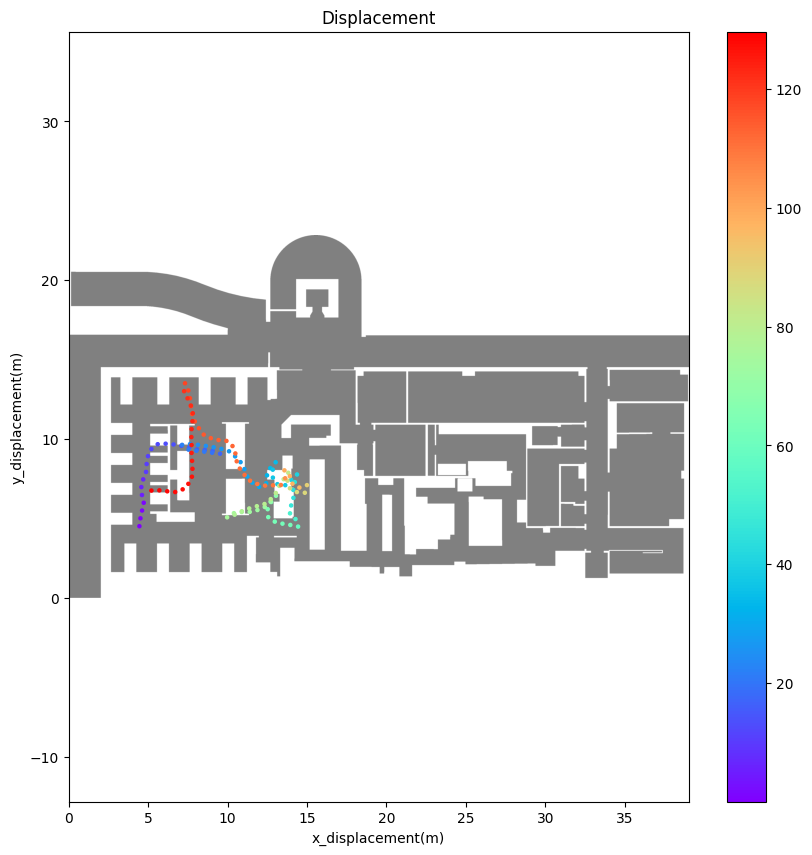

In [ ]:

# 軌跡前半の歩行軌跡の座標と強いBLEビーコンの位置座標の距離が最小になる角度を探索
# これは軌跡前半はドリフトが乗りづらいため
#時間全体の中央を変数に入れる

center_of_time = blescans.tail(1)['ts'].values[0]/2
first_half_strong_blescans= filter_strong_blescans(blescans,center_of_time,-76)
merged_strong_blescans_first_half = load_beacons_and_merge(BEACON_LIST_PATH, first_half_strong_blescans)

angle=search_optimal_angle(cumulative_displacement_df,gt_ref,merged_strong_blescans_first_half)

rotate_by_first_half_angle= pd.DataFrame({
    "ts":angle_in_step_timing.ts,
    "x":angle_in_step_timing.x+angle    
})


#csvファイルに保存
rotate_by_first_half_angle.to_csv('./output/rotate_by_first_half_angle.csv', index=False,columns=['ts','x'])


rotate_by_first_half_angle_displacement = calculate_cumulative_displacement(
    rotate_by_first_half_angle.ts, rotate_by_first_half_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])

plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(rotate_by_first_half_angle_displacement.x_displacement, rotate_by_first_half_angle_displacement.y_displacement,
                c=rotate_by_first_half_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()



{'drift': -0.002000000000000007, 'euclidean_distance': 1.5357694574065501}


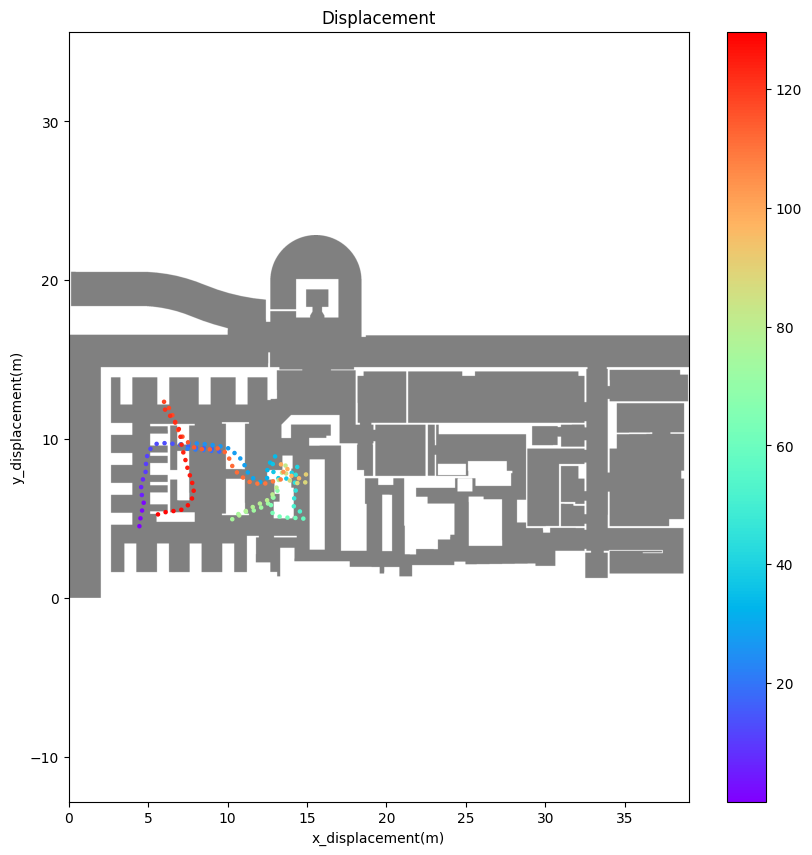

In [ ]:

def search_optimal_drift_from_angle(angle:pd.DataFrame,gt_ref:pd.DataFrame):
    original_angle = angle.copy()
    # 探索するドリフトの範囲
    drift_range = np.arange(-0.01, 0.01, 0.001)
    drift_and_euclidean_list:list[dict[str,float]] = []

    for drift in drift_range: 
        angle_copy = original_angle.copy()

        elapsed_time = angle_copy['ts'] - angle_copy['ts'].iloc[0]
        
        # ドリフトを経過時間に応じて増加させる
        angle_copy['x'] -= drift * elapsed_time  

        cumulative_displacement_df_copy = calculate_cumulative_displacement(
            angle_copy.ts, angle_copy['x'],0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]})
        cumulative_displacement_df_copy.reset_index(inplace=True, drop=True)
        # cumulative_displacement_df_copyの最後の行の値を取得
        last_row = cumulative_displacement_df_copy.tail(1)
        # ユークリッド距離を計算
        euclidean_distance = np.sqrt(
            (last_row['x_displacement'].values[0]-gt_ref.x[1])**2 + (last_row['y_displacement'].values[0]-gt_ref.y[1])**2)
        drift_and_euclidean_list.append({"drift":drift,"euclidean_distance":euclidean_distance})


    # 一番ユークリッド距離が小さいドリフトを取得
    optimal_drift_and_euclidean = min(drift_and_euclidean_list, key=lambda x: x['euclidean_distance'])

    return optimal_drift_and_euclidean

optimal_drift_and_euclidean=search_optimal_drift_from_angle(rotate_by_first_half_angle,gt_ref)
print(optimal_drift_and_euclidean)


first_time_remove_drift_angle= pd.DataFrame({
    "ts":rotate_by_first_half_angle.ts,
    "x":rotate_by_first_half_angle.x-optimal_drift_and_euclidean['drift']*(rotate_by_first_half_angle.ts-rotate_by_first_half_angle.ts.iloc[0])
})


first_time_remove_drift_angle_displacement = calculate_cumulative_displacement(
    first_time_remove_drift_angle.ts, first_time_remove_drift_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])

plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(first_time_remove_drift_angle_displacement.x_displacement, first_time_remove_drift_angle_displacement.y_displacement,
                c=first_time_remove_drift_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()



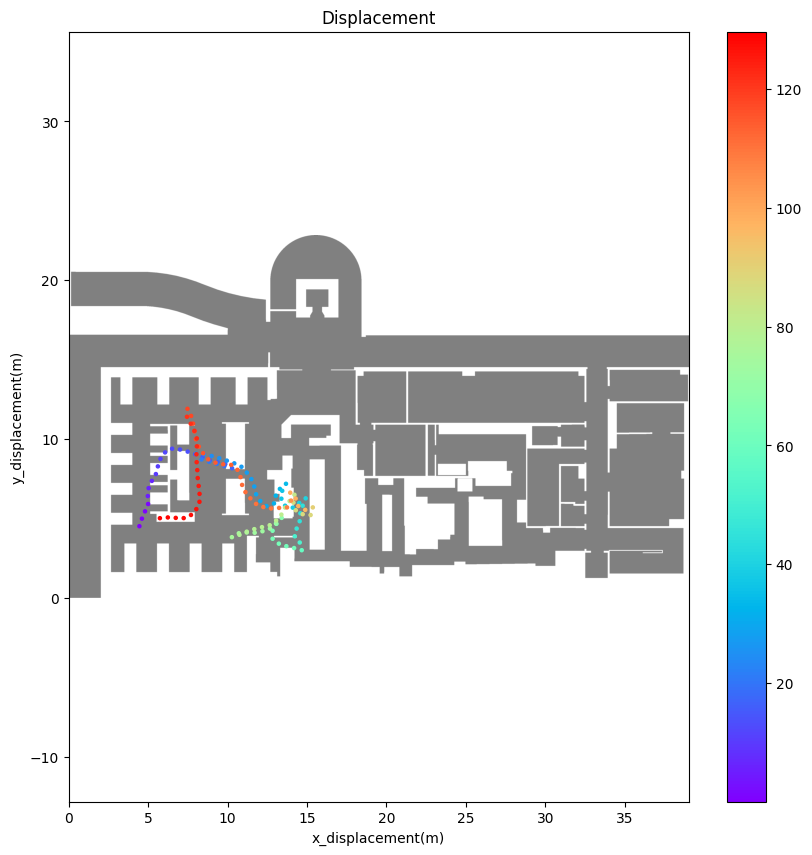

In [ ]:
# 軌跡全体の歩行軌跡の座標と強いBLEビーコンの位置座標の距離が最小になる角度を探索見つける
overall_strong_blescans= filter_strong_blescans(blescans,blescans.tail(1)['ts'].values[0],-76)
merged_strong_blescans_overall = load_beacons_and_merge(BEACON_LIST_PATH, overall_strong_blescans)

overall_strong_ble_angle = search_optimal_angle(first_time_remove_drift_angle_displacement,gt_ref,merged_strong_blescans_overall)

rotate_by_overall_strong_ble_angle= pd.DataFrame({
    "ts":first_time_remove_drift_angle.ts,
    "x":first_time_remove_drift_angle.x+overall_strong_ble_angle
})


rotate_by_overall_strong_ble_angle_displacement = calculate_cumulative_displacement(
    rotate_by_overall_strong_ble_angle.ts, rotate_by_overall_strong_ble_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])

plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(rotate_by_overall_strong_ble_angle_displacement.x_displacement, rotate_by_overall_strong_ble_angle_displacement.y_displacement,
                c=rotate_by_overall_strong_ble_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

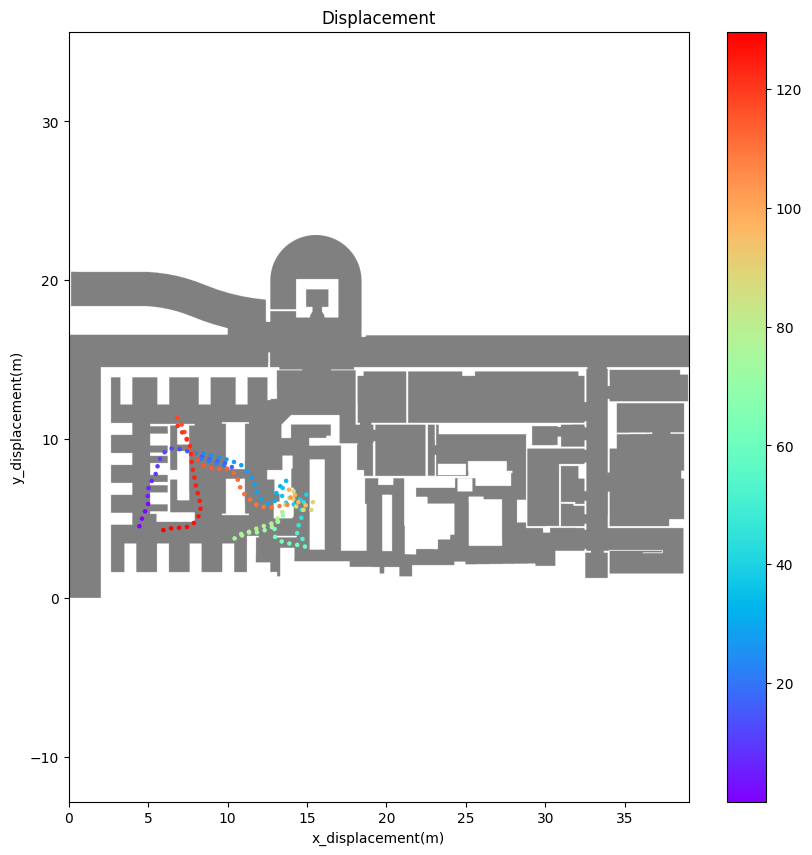

In [ ]:



second_optimal_drift_and_euclidean=search_optimal_drift_from_angle(rotate_by_overall_strong_ble_angle,gt_ref)

second_time_remove_drift_angle= pd.DataFrame({
    "ts":rotate_by_overall_strong_ble_angle.ts,
    "x":rotate_by_overall_strong_ble_angle.x-second_optimal_drift_and_euclidean['drift']*(rotate_by_overall_strong_ble_angle.ts-rotate_by_overall_strong_ble_angle.ts.iloc[0])
})

second_time_remove_drift_angle_displacement = calculate_cumulative_displacement(
    second_time_remove_drift_angle.ts, second_time_remove_drift_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])

plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(second_time_remove_drift_angle_displacement.x_displacement, second_time_remove_drift_angle_displacement.y_displacement,
                c=second_time_remove_drift_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()



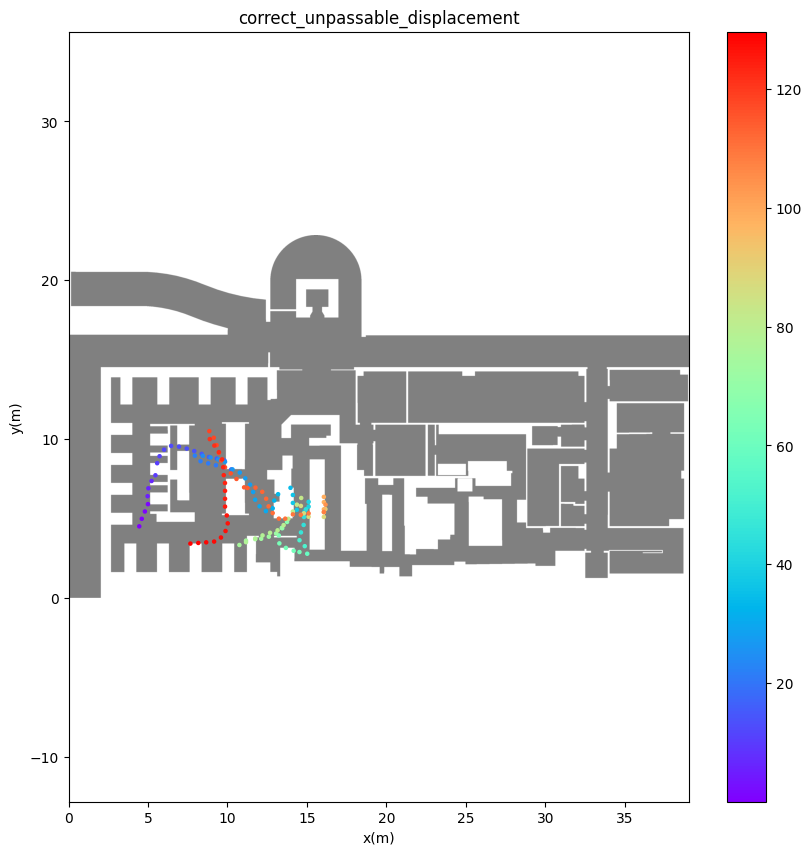

In [ ]:
from collections import deque



def is_passable(passable_dict, floor_name, x, y, dx, dy):
    epsilon = 1e-9  # 非常に小さい値

    # 不動小数点の切り捨てによる誤差を防ぐために、微小な値を足している
    # 例えば32.51の場合微小な値を足さないと3250.9999999999995となり、3250に切り捨てられてしまう
    row = int((x+epsilon) / dx)
    col = int((y+epsilon) / dy)

    if row < 0 or col < 0 or row >= passable_dict[floor_name].shape[0] or col >= passable_dict[floor_name].shape[1]:
        return False

    passable = passable_dict[floor_name][row, col]
    return passable


def find_nearest_passable_point(passable_dict, floor_name, start_x, start_y, dx, dy):
    start_row = int(start_x / dx)
    start_col = int(start_y / dy)

    queue = deque([(start_row, start_col)])
    visited = set((start_row, start_col))

    if start_row < 0 or start_col < 0 or start_row >= passable_dict[floor_name].shape[0] or start_col >= passable_dict[floor_name].shape[1]:
        return None

    while queue:
        current_row, current_col = queue.popleft()

        if passable_dict[floor_name][current_row, current_col]:
            return current_row * dx, current_col * dy

        for neighbor_row, neighbor_col in [(current_row-1, current_col), (current_row, current_col+1), (current_row+1, current_col), (current_row, current_col-1)]:
            if (0 <= neighbor_row < passable_dict[floor_name].shape[0] and 0 <= neighbor_col < passable_dict[floor_name].shape[1] and (neighbor_row, neighbor_col) not in visited):
                queue.append((neighbor_row, neighbor_col))
                visited.add((neighbor_row, neighbor_col))

    return None

def correct_unpassable_points(cumulative_displacement_df:pd.DataFrame, map_dict, floor_name, dx, dy):
    cumulative_displacement_df = cumulative_displacement_df.copy().reset_index(drop=True)
    corrected_displacement_df = cumulative_displacement_df

    for index,rows in cumulative_displacement_df.iterrows():
        nearest_row = corrected_displacement_df.iloc[index] 
    
        if not is_passable(map_dict, floor_name, nearest_row['x_displacement'], nearest_row['y_displacement'], dx, dy):
            before_of_correction_point={
                'x':nearest_row['x_displacement'],
                'y':nearest_row['y_displacement'],
            }

            corrected_point = find_nearest_passable_point(map_dict, floor_name, nearest_row['x_displacement'], nearest_row['y_displacement'], dx, dy) 
            if corrected_point is None:
                continue

            after_of_correction_point={
                'x': corrected_point[0],
                'y': corrected_point[1],
            }

            delta_x = after_of_correction_point['x'] - before_of_correction_point['x']
            delta_y = after_of_correction_point['y'] - before_of_correction_point['y']

            # 平行移動
            corrected_displacement_df.loc[index:, ['x_displacement', 'y_displacement']] += [delta_x, delta_y]
            

    return corrected_displacement_df

np.set_printoptions(threshold=np.inf)

correct_unpassable_displacement = correct_unpassable_points(second_time_remove_drift_angle_displacement[second_time_remove_drift_angle_displacement['ts']<180], map_dict, floor_name, dx, dy)

plot_map(
    map_dict,
    floor_name,
    dx,
    dy,
)

plt.colorbar(
    plt.scatter(
        correct_unpassable_displacement['x_displacement'],
        correct_unpassable_displacement['y_displacement'],
        c=correct_unpassable_displacement['ts'],
        cmap='rainbow',
        s=5
    )
)


plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.title('correct_unpassable_displacement')
plt.show()



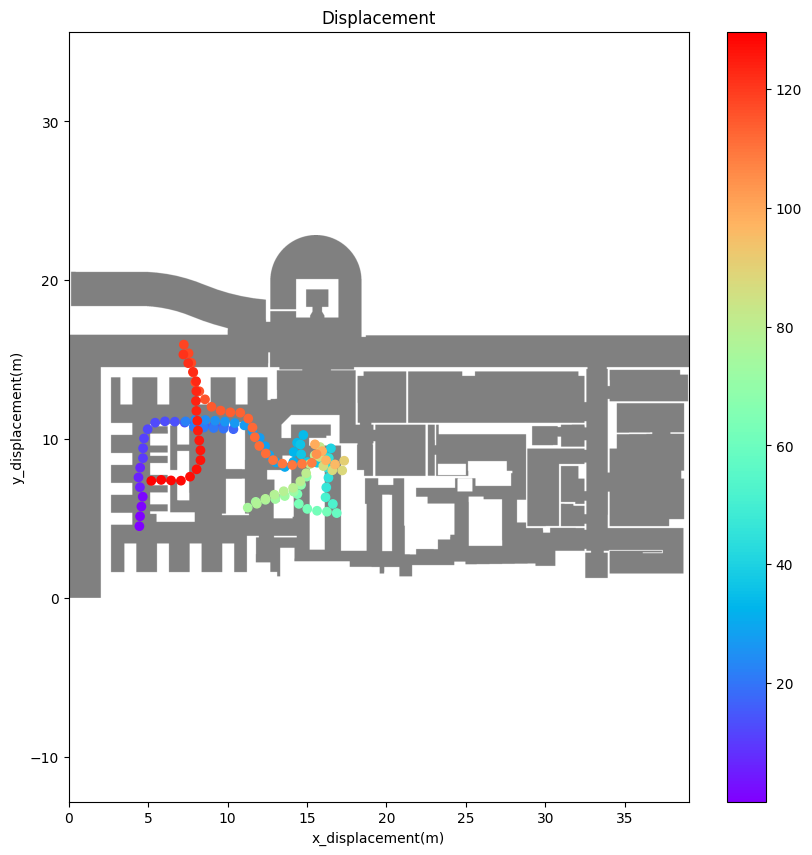

In [ ]:
#BLEの強いいくつかの点で回転させる

strong_blescans = filter_strong_blescans(blescans, 180, -65)
strong_blescans = load_beacons_and_merge(BEACON_LIST_PATH, strong_blescans)


before_of_correction = cumulative_displacement_df.iloc[(
            cumulative_displacement_df['ts'] - strong_blescans['ts'].values[0]).abs().argsort()[:1]]
before_of_correction_point = {"x":before_of_correction.x_displacement.values[0],"y":before_of_correction.y_displacement.values[0]}
after_of_correction_point = {"x": strong_blescans.x.values[0],"y": strong_blescans.y.values[0]}


# 回転と拡大
new_df = compute_affine_transformation(
    {"x":gt_ref.x[0],"y":gt_ref.y[0]}, before_of_correction_point, after_of_correction_point, cumulative_displacement_df)

plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(new_df.x_displacement, new_df.y_displacement, c=new_df.ts, cmap="rainbow"))


plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

/var/folders/9p/p2bfdpzj5v5fs4xvn07kwlww0000gn/T/ipykernel_57537/37318766.py:172: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'max' instead.
  idx:pd.Series = df.groupby(['interval_index'])['rssi'].transform(max) == df['rssi']


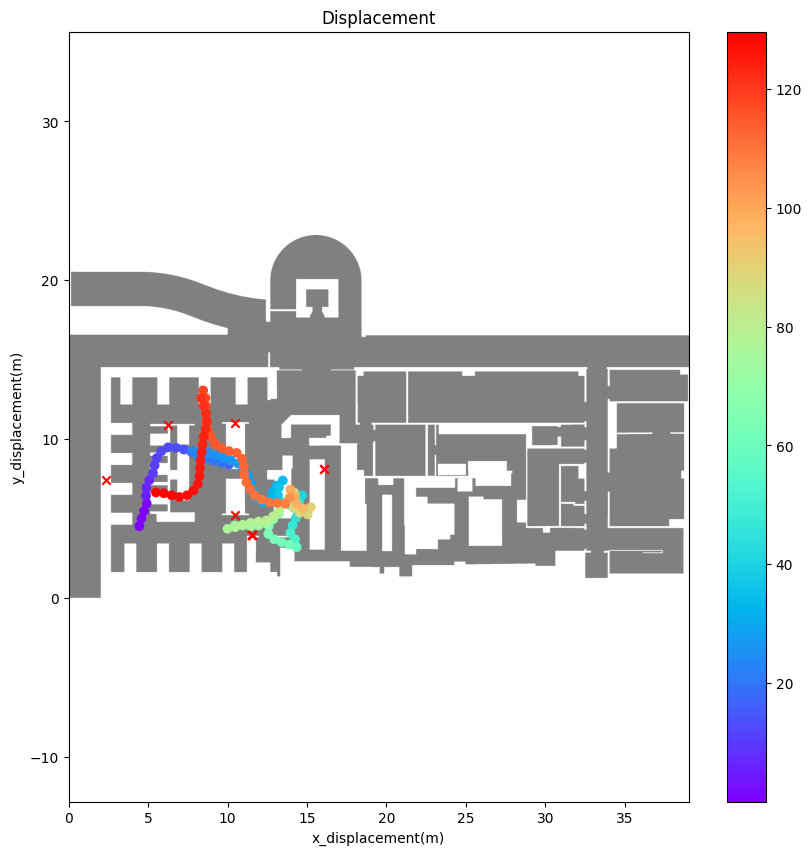

In [ ]:


strong_blescans = filter_strong_blescans(blescans, 180, -76)
strong_blescans = load_beacons_and_merge(BEACON_LIST_PATH, strong_blescans)
strong_blescans = filter_strongest_beacon_per_interval(strong_blescans, interval_seconds=10)

optimal_angle=search_optimal_angle(cumulative_displacement_df,gt_ref,strong_blescans)


all_nearest_row=pd.DataFrame()
for _, row in strong_blescans.iterrows():
    # のtsとstrong_blescansのtsが一番近い行を取得
    nearest_row = cumulative_displacement_df.iloc[(
        cumulative_displacement_df['ts'] - row['ts']).abs().argsort()[:1]]
    # concat
    all_nearest_row = pd.concat([all_nearest_row, nearest_row])
    

# 回転のみ
new_df = rotate_cumulative_displacement(cumulative_displacement_df, optimal_angle,{'x':gt_ref.x[0],'y':gt_ref.y[0]})



plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(new_df.x_displacement, new_df.y_displacement, c=new_df.ts, cmap="rainbow"))

# plt.scatter(all_nearest_row.x_displacement, all_nearest_row.y_displacement, c='red', marker='x')
plt.scatter(strong_blescans.x, strong_blescans.y, c='red', marker='x')

plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

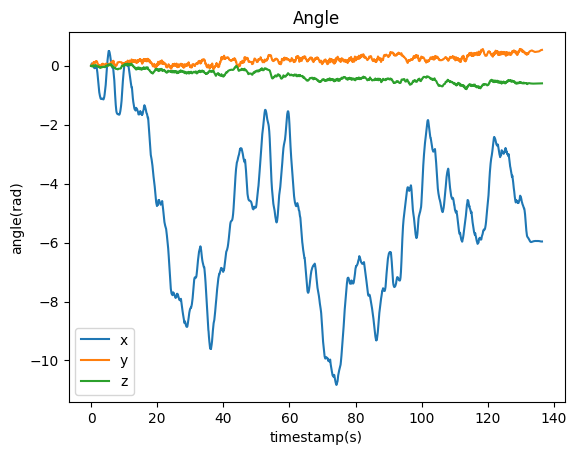

In [ ]:

angle = pd.DataFrame()


# 角速度を積分して角度に変換
angle["x"] = np.cumsum(gyro["x"] * (gyro["ts"].diff().fillna(0)))
angle["y"] = np.cumsum(gyro["y"] * (gyro["ts"].diff().fillna(0)))
angle["z"] = np.cumsum(gyro["z"] * (gyro["ts"].diff().fillna(0)))
angle['ts'] = gyro['ts']

plt.plot(angle.ts, angle[["x", "y", "z"]], label=["x", "y", "z"])
plt.xlabel("timestamp(s)")
plt.ylabel("angle(rad)")
plt.title("Angle")
plt.legend()
plt.show()



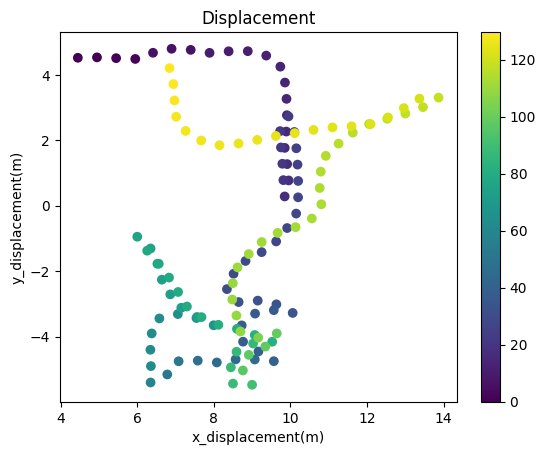

In [ ]:

peek_angle = match_data(angle, acc.ts[peaks])

cumulative_displacement_df = calculate_cumulative_displacement(
    peek_angle.ts, peek_angle.x, 0.5,{'x':gt_ref.x[0],'y':gt_ref.y[0]})

cumulative_displacement_df.reset_index(inplace=True, drop=True)

# 原点スタートのx,y座標上に出力
plt.colorbar(plt.scatter(cumulative_displacement_df.x_displacement,
             cumulative_displacement_df.y_displacement, c=cumulative_displacement_df.ts))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

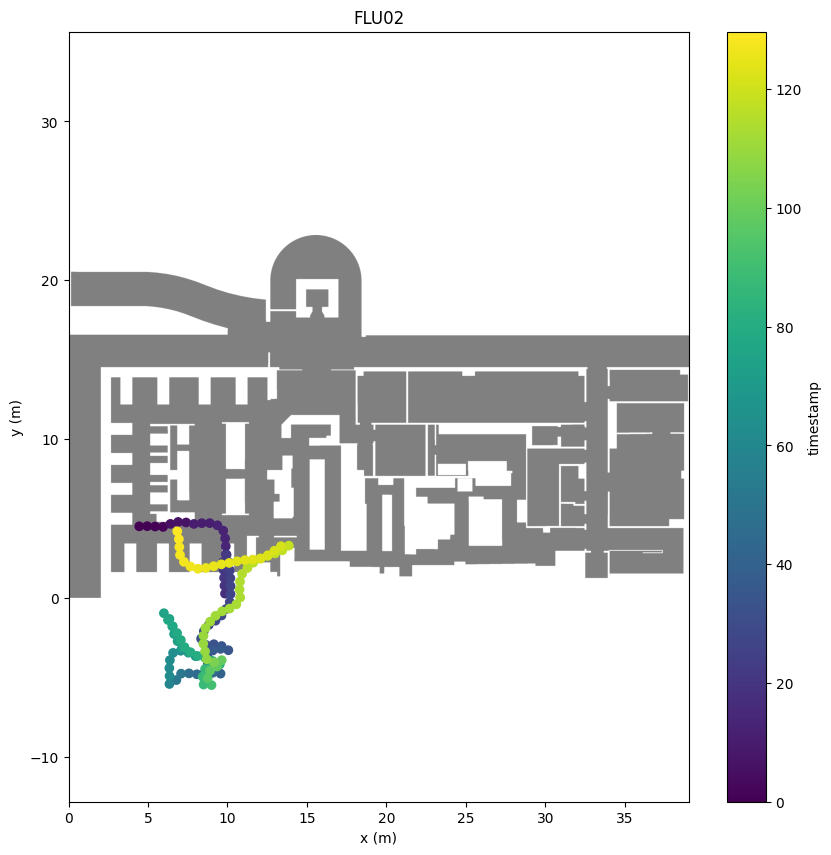

In [ ]:

# 1 pixel of bmp represents 0.01 m
dx = 0.01
dy = 0.01

# read bitmap image of the floor movable areas
map_dict = {}
for floor_name in FLOOR_NAMES:
    map_dict[floor_name] = load_bitmap(
        GIS_BASE_PATH + floor_name + "_0.01_0.01.bmp")

df_gt = pd.read_csv(GT_CSV_PATH)
floor_name = df_gt.floor.mode()[0]  # get the floor name in the ground truth

plot_map(map_dict,floor_name,dx,dy)
plt.colorbar(plt.scatter(cumulative_displacement_df.x_displacement,
             cumulative_displacement_df.y_displacement, c=cumulative_displacement_df.ts),label="timestamp")

plt.show()

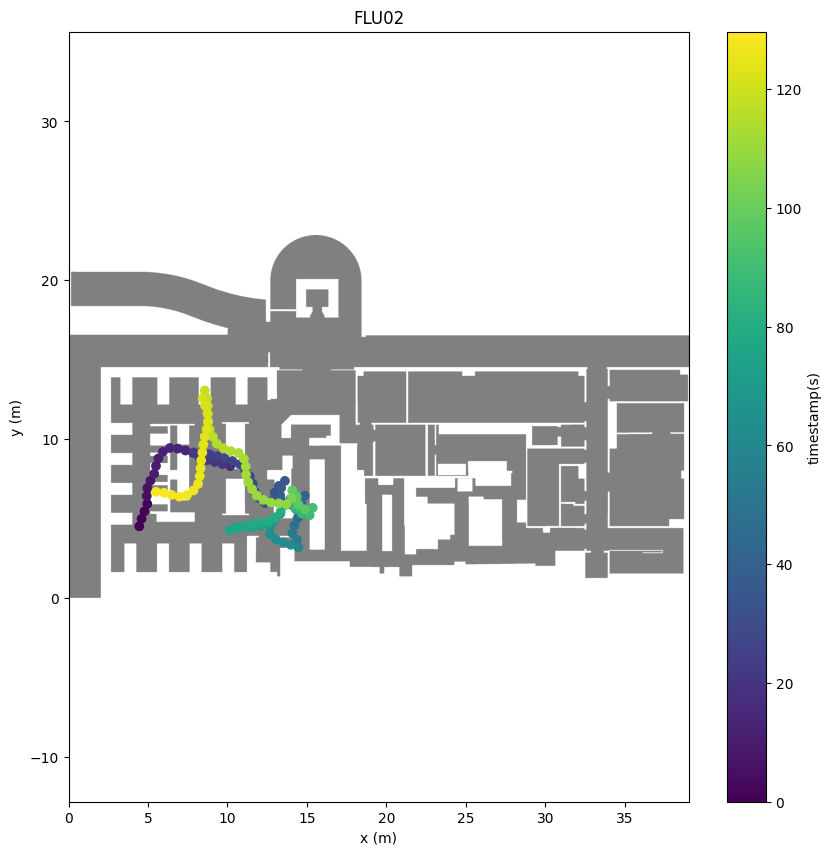

In [ ]:



plot_map(map_dict,floor_name,dx,dy)

new_df = rotate_cumulative_displacement(cumulative_displacement_df, 1.25,{'x':gt_ref.x[0],'y':gt_ref.y[0]})
plt.colorbar(plt.scatter(new_df.x_displacement, new_df.y_displacement,
                c=new_df.ts), label='timestamp(s)')


# plt.colorbar(plt.scatter(cumulative_displacement_df.x_displacement,
#                          cumulative_displacement_df.y_displacement, c=cumulative_displacement_df.ts),label="timestamp")





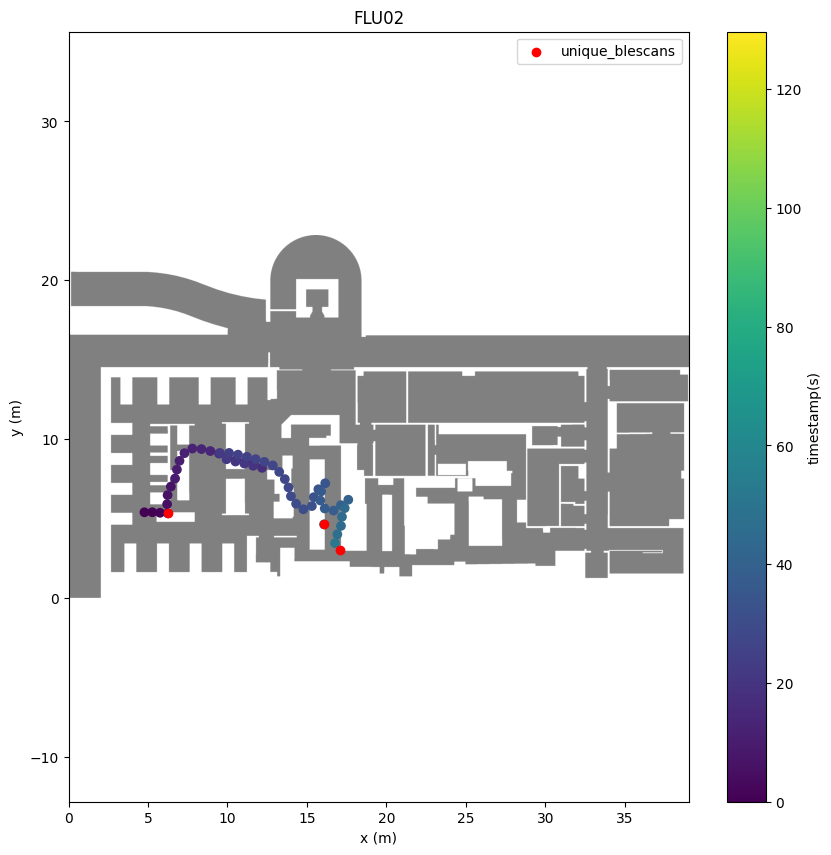

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


def run_simulation(unique_blescans, cumulative_displacement_df):
    previous_correction_index = 0
    previous_correction_point = {'x': 43.07, 'y': 12.16}

    for index, item in unique_blescans.iterrows():
        before_of_correction = cumulative_displacement_df.iloc[(
            cumulative_displacement_df['ts'] - item['ts']).abs().argsort()[:1]]

        before_of_correction_point = {
            'x': before_of_correction['x_displacement'].values[0],
            'y': before_of_correction['y_displacement'].values[0]
        }

        after_of_correction_point = {
            'x': item['x'],
            'y': item['y']
        }

        unchanged_cumulative_displacement_df = cumulative_displacement_df.iloc[:previous_correction_index]
        new_cumulative_displacement_df = compute_affine_transformation(
                previous_correction_point, before_of_correction_point, after_of_correction_point, cumulative_displacement_df.iloc[previous_correction_index:])
        cumulative_displacement_df = pd.concat(
            [unchanged_cumulative_displacement_df, new_cumulative_displacement_df])
        previous_correction_point = after_of_correction_point
        previous_correction_index = before_of_correction.index[0]

    return cumulative_displacement_df

def plot_results(tmp_cumulative_displacement_df, unique_blescans, map_dict, floor_name, dx, dy):
    # Plot the map
    plot_map(map_dict,floor_name,dx,dy)

    # Plot the displacements
    plt.colorbar(plt.scatter(tmp_cumulative_displacement_df['x_displacement'],
                             tmp_cumulative_displacement_df['y_displacement'], c=tmp_cumulative_displacement_df.ts), label='timestamp(s)')
    # Plot the unique blescans
    plt.scatter(unique_blescans.x, unique_blescans.y, c='r', label='unique_blescans')
    plt.legend()
    plt.show()

# Filter the strong blescans
strong_blescans = filter_strong_blescans(blescans, 180, -76)
strong_blescans = load_beacons_and_merge(BEACON_LIST_PATH, strong_blescans)
# strong_blescansをfor文で回す
unique_blescans = unique_blescans_fn(strong_blescans)

copy_cumulative_displacement_df = run_simulation(unique_blescans, cumulative_displacement_df)
plot_results(copy_cumulative_displacement_df, unique_blescans, map_dict, floor_name, dx, dy)









In [ ]:
import math

def calculate_orientation(mag_data, accel_data):
    # mag_data and accel_data should be dictionaries with 'x', 'y', 'z' keys
    # for example: mag_data = {'x': 40.3, 'y': -12.8, 'z': -30.6}
    # accel_data = {'x': 0.08, 'y': 0.10, 'z': 9.81}
    
    # Calculate pitch and roll from accelerometer data
    pitch = math.atan2(accel_data['x'], math.sqrt(accel_data['y']**2 + accel_data['z']**2))
    roll = math.atan2(accel_data['y'], math.sqrt(accel_data['x']**2 + accel_data['z']**2))

    # Apply the pitch and roll compensations to the magnetic data
    compensated_x = mag_data['x']*math.cos(pitch) + mag_data['y']*math.sin(roll)*math.sin(pitch) + mag_data['z']*math.cos(roll)*math.sin(pitch)
    compensated_y = mag_data['y']*math.cos(roll) - mag_data['z']*math.sin(roll)

    # Calculate the heading
    heading = math.atan2(compensated_y, compensated_x)

    # Convert the heading to degrees and adjust to 0-360 range
    heading_deg = (math.degrees(heading) + 360) % 360

    return heading_deg

# Test data
mag_data = {'x': 40.3, 'y': -12.8, 'z': -30.6}
accel_data = {'x': 0.08, 'y': 0.10, 'z': 9.81}

heading_deg = calculate_orientation(mag_data, accel_data)
